In [14]:
import numpy as np
import glob
import h5py

import matplotlib
matplotlib.use("Agg")

import matplotlib.pyplot as plt
%matplotlib inline

import gwpy
from gwpy import segments
from gwpy.timeseries import TimeSeries
from gwpy.timeseries import StateVector
from gwpy import frequencyseries
import gwpy.astro

import json

from scipy.interpolate import interp1d
from astropy import cosmology, units as u
from pycbc.frame import StatusBuffer
from pycbc.frame import read_frame
from pycbc.filter import matched_filter, highpass, lowpass, sigma, resample_to_delta_t
from pycbc.psd import interpolate, inverse_spectrum_truncation, welch
from pycbc.types.frequencyseries import FrequencySeries

from pycbc.waveform import get_td_waveform, TemplateBank
from pycbc.detector import Detector
from pycbc.psd import interpolate

from tqdm import tqdm
# import ligo.skymap.plot
from gwpy.astro import inspiral_range

(1420878061, 1420878149, 88)


Strain Data of H1 in the segment (1420878061, 1420878149, 88) is loaded.
(1420878061, 1420878149, 88)
Strain Data of L1 in the segment (1420878061, 1420878149, 88) is loaded.


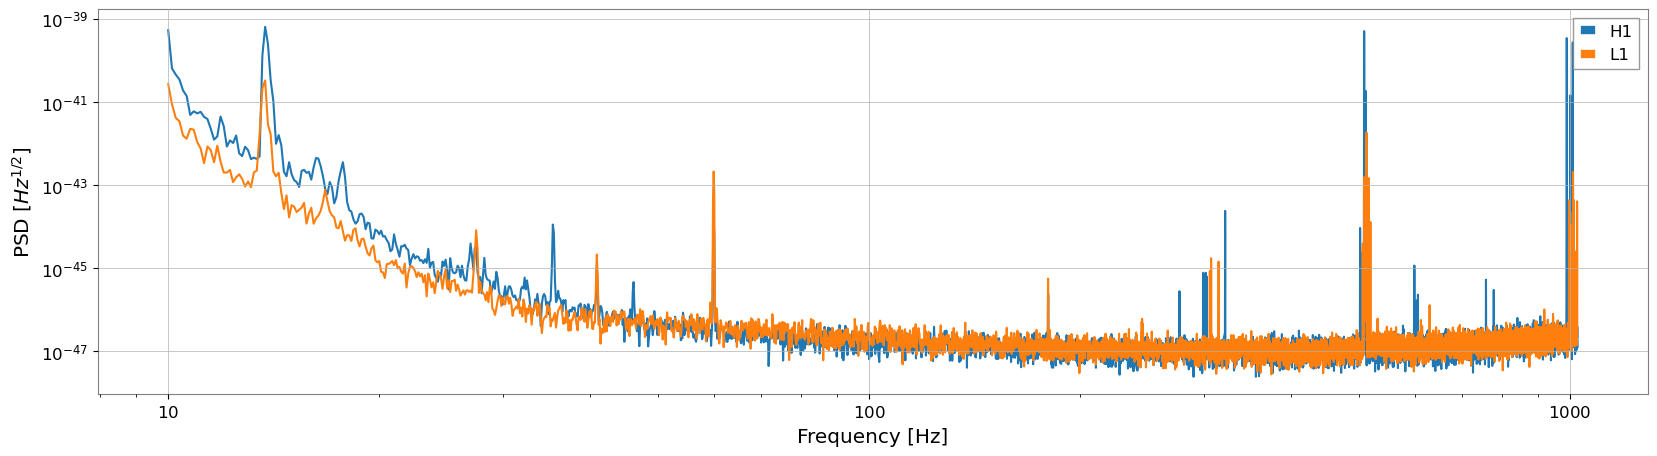

In [11]:
# Config
ifos = ["H1", "L1"]
ts_dict = dict.fromkeys(ifos)
psd_dict = dict.fromkeys(ifos)
gwpy_ts_dict = dict.fromkeys(ifos)
gwpy_psd_dict = dict.fromkeys(ifos)
for ifo in ifos:
    channels = [
        f"{ifo}:GDS-CALIB_STATE_VECTOR_AR",
        f"{ifo}:GDS-CALIB_STRAIN_CLEAN_AR",
    ]
    # trigger_time = 1384782888.7
    # time_label = 138
    trigger_time = 1420878141.22
    time_label = 142
    psd_length = 64
    before_trigger_length = psd_length + 16
    after_trigger_length = 8
    full_length = before_trigger_length + after_trigger_length
    start = int(trigger_time) - before_trigger_length
    end = int(trigger_time) + after_trigger_length
    duration = end - start
    print((start, end, duration))
    data_dir = f"/archive/frames/O4/hoft_C00_AR/{ifo}/{ifo[0]}-{ifo}_HOFT_C00_AR-{time_label}"
    source = glob.glob(f"{data_dir}/*.gwf")
    fftlength = 8
    overlap = 4
    window_length = 10

    # Check data quality and load data
    sv = StateVector.read(
        source=source,
        channel=channels[0],
        start=start,
        end=end,
    )
    bit_dict = sv.get_bit_series(bits=['Bit 0', 'Bit 1'])
    bit_series_0 = bit_dict['Bit 0']
    bit_series_1 = bit_dict['Bit 1']
    bit_check = (bit_series_0 * bit_series_1).all()
    if bit_check == True:
        gwpy_ts = TimeSeries.read(
            source=source,
            channel=channels[1],
            start=start,
            end=end,
        )
        ts_dict[ifo] = gwpy_ts.to_pycbc()
        gwpy_ts_dict[ifo] = gwpy_ts
        print(f"Strain Data of {ifo} in the segment {(start, end, duration)} is loaded.")
    else:
        raise RuntimeError(f"Data Quality check faild for {ifo} data in the segment {(start, end, duration)}.")

    # Calculate PSD
    ts = ts_dict[ifo]
    psd_ts = ts.crop(0,full_length-psd_length)
    psd = psd_ts.psd(fftlength)
    psd_dict[ifo] = psd
    crop_st = gwpy_ts.t0.value
    crop_ed = crop_st + psd_length
    gwpy_ts = gwpy_ts.crop(crop_st, crop_ed)
    gwpy_psd = gwpy_ts.psd(
        fftlength=fftlength,
        overlap=fftlength/2,
        method='median',
    )
    gwpy_psd_dict[ifo] = gwpy_psd

flow, fhigh = 10, 1024
fst, fed = int(flow/psd.delta_f), int(fhigh/psd.delta_f)
plt.figure(figsize=[20,5])
for ifo in ifos:
    plt.plot(psd_dict[ifo].sample_frequencies[fst:fed], psd_dict[ifo][fst:fed], label=ifo)

plt.xlabel("Frequency [Hz]")
plt.ylabel(r"PSD [$Hz^{1/2}$]")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

In [4]:
def read_psd(filename, delimiter=" "):
    data = np.loadtxt(filename, delimiter=delimiter)
    freqs = data[:,0]
    value = data[:,1]
    fs = FrequencySeries(value, delta_f=freqs[1])

    return fs

In [34]:
# psd_dir = "/home/chiajui.chou/beacon_data"
psd_dir = "/home/chiajui.chou/beacon-data"
ifos = ["H1", "L1"]
# psd_ids = ["p4k", "p8k", "p8k_q3"]
psd_ids = ["p8k_q3_win4", "p8k_q3_win8", "p8k_q3_win16", "p8k_q3_win32"]
psd_collection = dict.fromkeys(psd_ids)

for psd_id in psd_collection.keys():
    psd_collection[psd_id] = dict.fromkeys(ifos)
    for ifo in ifos:
        psd_collection[psd_id][ifo] = read_psd(f"{psd_dir}/PSD_{ifo}_{psd_id}.dat")

# Plotting PSD
    # for ifo  in ifos:
    #     plt.title(f"PSD_{psd_id}")
    #     plt.plot(psd_collection[psd_id][ifo].sample_frequencies, psd_collection[psd_id][ifo], label=ifo, alpha=0.5)
    #     plt.xlim(10, 1024)
    #     plt.ylim(1e-48, 1e-30)
    #     plt.xscale('log')
    #     plt.yscale('log')
    #     plt.xlabel('Frequency [Hz]')
    #     plt.ylabel('PSD[1/Hz]')
    #     plt.legend()

    # plt.show()

In [35]:
ifos = ["H1", "L1"]
seqarima_psd_collection = dict.fromkeys(psd_ids)
for psd_id in psd_ids:
    seqarima_psds = dict.fromkeys(ifos)
    for ifo in ifos:
        seqarima_psds[ifo] = frequencyseries.FrequencySeries(
            psd_collection[psd_id][ifo],
            f0 = psd_collection[psd_id][ifo].sample_frequencies[0],
            df = psd_collection[psd_id][ifo].delta_f,
        )

    seqarima_psd_collection[psd_id] = seqarima_psds

In [37]:
ifo = "L1"
psd_id = "p8k_q3"
fmin, fmax = 20, 1024

for psd_id in psd_ids:
    print(psd_id)
    for ifo in ifos:
        # bns_range = inspiral_range(
        #     gwpy_psd_dict[ifo],
        #     fmin=fmin,
        #     fmax=fmax,
        # )
        bns_range_seqarima= inspiral_range(
            seqarima_psd_collection[psd_id][ifo],
            fmin=fmin,
            fmax=fmax,
        )
        # print(f"{ifo} Welch: {bns_range}")
        print(f"{ifo} seqARIMA: {bns_range_seqarima}")

p8k_q3_win4
H1 seqARIMA: 227.02565044364684 Mpc
L1 seqARIMA: 197.67975472391774 Mpc
p8k_q3_win8
H1 seqARIMA: 214.20111300421289 Mpc
L1 seqARIMA: 203.55259289341944 Mpc
p8k_q3_win16
H1 seqARIMA: 203.7717327992216 Mpc
L1 seqARIMA: 201.41170868972557 Mpc
p8k_q3_win32
H1 seqARIMA: 198.31445302344065 Mpc
L1 seqARIMA: 194.74810742857022 Mpc
